This is notebook is for exploring and understanding the datasets and preparing data for later machine learning models.

> ### Key parts in this notebook

### Analyze `Portfolio` data

In this part we will take a look at the promotion offers. There are 10 different promotions that belong to 3 general types. There are 4 features that describe the promotions: channels, difficulty, duration and reward. We found out that discount promotions usually have long durations and high difficulties while buy-one-get-one promotions have shorter durations and lower difficulties. Discount promotions will have higher reward. 

### Analyze `Profile` data

In this part we will take a look at customers' demographic data.

`Age`: 12.8% of the data are missing. About half the customers are between 50 and 80 years old.
<br>`Gender`: 1.4% of the data are missing. 57.2% of the customers are males.
<br>`Customer age (how long the customer has been with us)`: 56% of the customers joined in the past 3 years.
<br>`Income`: 12.8% of the data are missing. Income seems to be corrrelated with age. In this simulated dataset, different age buckets have different limits of maximum incomes. For people under 40 years old, their income won't exceed 
80k and for people under 50 years old, their income won't exceed 100k. For older people, the maximum income is about 120k. About 40% of the income numbers are between 50k and 80k.

### Analyze `Transcript` data

There are 4 types of transcripts: `normal transaction`, `offer received`, `offer viewed` and `offer complete`. 

In total we offered 76,277 promotions and there are 63,288 unique person + offer_type combinations. Only 6 people didn't revceive any offer.

**Each person can receive the same type of offer for multiple times** and the offer id only tells what type of offer that is ---- it can't be used to recognize a unique offer. Our challenge here is to match the various actions to tell if a certain offer was viewed or completed. Also, customers might not receive all types of offers.

**We solve this problem by giving an order number of the transactions for each customer. The offer id plus the rank can be seen as a "unique ID" for that offer.** We discovered that until the current offer expires, the app won't send another offer under the same type to that customer (we will prove this later). We will attribute the earlist following actions (view the offer or complete the offer) to the earliest offer (under the same offer id) with an extra condition that the following actions need to happen before that offer expires.

*After matching offer_received with offer_viewed and offer_complete, we build out the funnel for each promotion sent:*

offer_received 
<br>|__ offer viewed 
<br>&nbsp; &nbsp; &nbsp; |__ offer completed
<br>&nbsp; &nbsp; &nbsp; |__ offer not completed
<br>|__ offer not viewed
<br>&nbsp; &nbsp; &nbsp; |__ offer completed
<br>&nbsp; &nbsp; &nbsp; |__ offer not completed

74.16% of the offers were viewed (while a small portion of them were viewed after they were completed); 12.86% of the offers were viewed without being completed. Among the viewed offers, 66.96% of the offers were viewed within 1 day after the offer were received. 13.54% of the offer were completed within one day after being viewed.

In general, offers that are viewed are more likely to be completed, especially for discount promotions. Female customers, older (> 35) customers, wealthier customers and customers who joined earlier are more valuable.

# 1. Load Data and Packages

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

# 2. Understand the data

# 2.1 Analyze `portfolio` data

Portfolio dataset shows the information about the promos.

Explanation of the data:

**reward: (numeric)** money awarded for the amount spent
<br>**channels: (list)** web, email, mobile, social
<br>**difficulty: (numeric)** money required to be spent to receive reward
<br>**duration: (numeric)** time for offer to be open, in days
<br>**offer_type: (string)** bogo, discount, informational

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


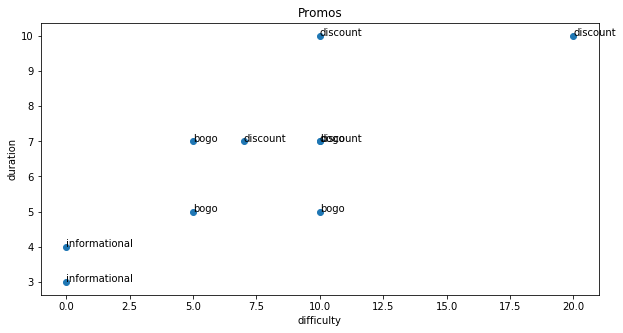

In [3]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(portfolio['difficulty'], portfolio['duration'])
plt.xlabel('difficulty')
plt.ylabel('duration')
plt.title("Promos")

for i, txt in enumerate(portfolio['offer_type']):
    ax.annotate(txt, (portfolio['difficulty'][i], portfolio['duration'][i]))

Discount promotions usually have long duration and high difficulties while buy-one-get-one promotions have shorter duration and lower difficulties. Discount promotions will have higher reward. In general, longer promotions will have higher difficulties.

In [4]:
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [5]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,web,mobile,email,social
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


# 2.2 Analyze `profile` data

Profile data has customers' demographic information.

**gender: (categorical)** M, F, O, or null
<br>**age: (numeric)** missing value encoded as 118
<br>**id**: (string/hash)
<br>**became_member_on**: (date) format YYYYMMDD
<br>**income**: (numeric)

In [6]:
profile.shape

(17000, 5)

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


### 2.2.1 Age

Text(0.5, 1.0, 'Age distribution')

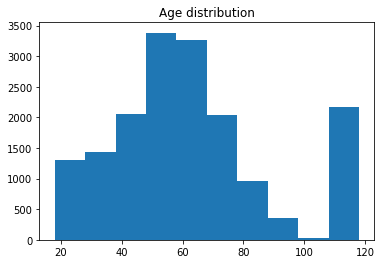

In [8]:
plt.hist(profile['age'])
plt.title("Age distribution")

Some people have wierd age numbers. We need to consider those values as missing values.

In [9]:
sum(profile['age'] > 100) / len(profile)

0.12823529411764706

We will now create age buckets for future visulizations and analysis.

In [77]:
def bucket_age(x):
    x = float(x)
    if x < 25 :
        return "0 ~ 24"
    elif x >= 25 and x <= 34:
        return "25 ~ 34"
    elif x >= 35 and x <= 44:
        return "35 ~ 44"
    elif x >= 45 and x <= 54:
        return "45 ~ 54"
    elif x >=55 and  x <= 64:
        return "55 ~ 64"
    elif x is None:
        return float('nan')
    else:
        return "65 ~"

profile.loc[profile['age'] > 100, 'age'] = float('nan')
profile['age_bucket'] = profile['age'].apply(bucket_age)

In [78]:
profile['age_bucket'].value_counts(normalize=True)

65 ~       0.378882
55 ~ 64    0.201235
45 ~ 54    0.177235
35 ~ 44    0.109941
25 ~ 34    0.081176
0 ~ 24     0.051529
Name: age_bucket, dtype: float64

In [79]:
sum((profile['age']>=50) & (profile['age']<=80)) / len(profile)

0.4958823529411765

### 2.2.2 Gender

In [13]:
profile['gender'].value_counts(normalize=True)

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

1.4% of the values are missing.

### 2.2.3 Customer age (how many months since the customer first joined)

In [14]:
now = pd.to_datetime(datetime.strftime(datetime.now(), '%Y-%m-%d'), format="%Y/%m/%d")

def format_date(x):
    x = str(x)
    that_day = pd.to_datetime(x, format="%Y%m%d")
    return (now - that_day).days/30

In [15]:
profile['customer_age'] = profile['became_member_on'].apply(format_date)

Text(0.5, 0, 'months')

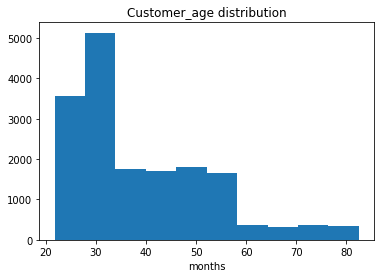

In [16]:
plt.hist(profile['customer_age'])
plt.title("Customer_age distribution")
plt.xlabel('months')

In [17]:
sum(profile['customer_age'] <= 36) / len(profile)

0.5477647058823529

The "oldest" customer joined about 6 years ago! 

### 2.2.4 Income

/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Income')

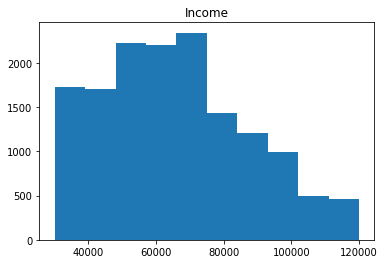

In [18]:
plt.hist(profile['income'])
plt.title('Income')

In [19]:
profile['income'].isna().sum() / len(profile)

0.12794117647058822

In [20]:
sum((profile['income']>50000) & (profile['income']<80000))/len(profile)

0.41611764705882354

Text(0.5, 1.0, 'Relationship between age and income')

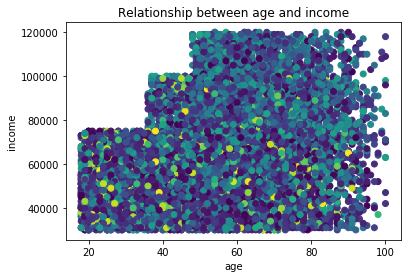

In [21]:
plt.scatter(profile['age'], profile['income'], c=profile['customer_age'])
plt.xlabel('age')
plt.ylabel('income')
plt.title("Relationship between age and income")

# 2.3 Analyze `Transcript` data

Transcript table records customers' transactions.

Explanation on the data:

**person**: (string/hash)
<br>**event**: (string) offer received, offer viewed, transaction, offer completed
<br>**value**: (dictionary) different values depending on event type
<br>**offer id**: (string/hash) not associated with any "transaction"
<br>**amount**: (numeric) money spent in "transaction"
<br>**reward**: (numeric) money gained from "offer completed"
<br>**time**: (numeric) hours after start of test

There are 4 types of transcript: normal transaction, offer received, offer viewed and offer complete. 

**Each person can receive the same type of offer for multiple times** and the offer id only tells what type of offer that is ---- it can't be used to recognize a unique offer. Our challenge here is to match the various actions to tell if a certain offer was viewed or completed. Also, customers might not received all types of offers.

**We solve this problem by giving an order number of the transactions for each customer. The offer id plus the rank can be seen as a "unique ID" for that offer.** We discovered that until the current offer expires, the app won't send another offer under the same type to that customer (we will prove this later). We will attribute the earlist following actions (view the offer or complete the offer) to the earliest offer (under the same offer id) with an extra condition that the following actions need to happen before that offer expires.

In [22]:
#Distribution of transaction types

transcript['event'].value_counts(normalize=True)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

In [23]:
transcript = pd.read_json('transcript.json', orient='records', lines=True).reset_index()

In [85]:
transcript.sample(frac=1).head()

,index,event,person,time,value,offer_id,amount,reward,rank_in_user
112281,112281,offer received,6006641a7b15444fae1ae0a7e27a88dd,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,8.0
167074,167074,offer viewed,b68bc936296144569115d7cbe8077f51,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,16.0
267219,267219,offer completed,d8ec9896d2a34515af66ccf7be5fbe66,588,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0,16.0
264754,264754,transaction,b1d541fa105e4b6f8f6c6a14831e938f,582,{'amount': 75.65},NaN,75.65,NaN,17.0
41932,41932,transaction,ec77e19f18ae42e5ac50e450f0e3f3e3,96,{'amount': 19.52},NaN,19.52,NaN,4.0


In [25]:
#We will use some custom functions to extract offer_id, reward or amount in the 'value' column

def get_offer_name1(x):
    try:
        return x['offer id']
    except:
        return float('nan')

def get_offer_name2(x):
    try:
        return x['offer_id']
    except:
        return float('nan') 
    
def get_amount(x):
    try:
        return x['amount']
    except:
        return float('nan')
    
def get_reward(x):
    try:
        return x['reward']
    except:
        return float('nan')

    
transcript['offer_id'] = transcript['value'].apply(get_offer_name1)
transcript.loc[(transcript['offer_id'].isna()), "offer_id"] = transcript['value'].apply(get_offer_name2)
transcript['amount'] = transcript['value'].apply(get_amount)
transcript['reward'] = transcript['value'].apply(get_reward)
transcript['rank_in_user'] = transcript.groupby('person')['index'].rank() #add a rank to help us attribute offer related activities

In [81]:
print("In total we offered {:,} promotions."\
      .format(len(transcript[transcript['event'] == "offer received"])))

In total we offered 76,277 promotions.


In [83]:
print("In total there are {:,} unique person + offer_type combinations."\
      .format(len(transcript[transcript['event'] == "offer received"][['person','offer_id']].drop_duplicates())))

In total there are 63,288 unique person + offer_type combinations.


> Customers can receive the same type of offer for multiple times.

In [28]:
transcript[transcript['event'] == "offer received"].groupby(['person']).count().reset_index().head()

,person,index,event,time,value,offer_id,amount,reward,rank_in_user
0,0009655768c64bdeb2e877511632db8f,5,5,5,5,5,0,0,5
1,00116118485d4dfda04fdbaba9a87b5c,2,2,2,2,2,0,0,2
2,0011e0d4e6b944f998e987f904e8c1e5,5,5,5,5,5,0,0,5
3,0020c2b971eb4e9188eac86d93036a77,5,5,5,5,5,0,0,5
4,0020ccbbb6d84e358d3414a3ff76cffd,4,4,4,4,4,0,0,4


In [29]:
transcript.to_csv("transcript_cleaned.csv", index=False)

> Customers might not receive all the offers.

## 2.3.1 Match offer_received with offer_viewed

In [30]:
#from_received_to_viewed is table that matches the offer_received and offer_viewed activities

from_received_to_viewed = transcript[transcript['event'] == "offer received"][['person', 'offer_id', 'event','time','rank_in_user']]\
                                        .merge(transcript[transcript['event'] == "offer viewed"][['person', 'offer_id', 'event','time','rank_in_user']], 
                                                  on=['person', 'offer_id'], how='left')\
                                        .merge(portfolio[['id','duration']].rename({'id':'offer_id'}, axis=1))

from_received_to_viewed['time_received_to_viewed'] = from_received_to_viewed['time_y'] - from_received_to_viewed['time_x']

#the offer_viewed action must happen after the offer_received action
#the offer_viewed action must be within the active duration of that offer
from_received_to_viewed = from_received_to_viewed[(from_received_to_viewed['rank_in_user_x'] < from_received_to_viewed['rank_in_user_y']) & \
                                                                           (from_received_to_viewed['time_received_to_viewed'] <= from_received_to_viewed['duration']*24)]

#After the filters above, match the first offer_view with the first offer_received, the 2nd offer view with the 2nd offer_completed, ..., etc
from_received_to_viewed = from_received_to_viewed\
                                        .sort_values('rank_in_user_y').groupby(['person','offer_id','rank_in_user_x']).first().reset_index()\
                                        .sort_values('rank_in_user_x').groupby(['person','offer_id','rank_in_user_y']).first().reset_index()

from_received_to_viewed['time_received_to_viewed'] = (from_received_to_viewed['time_y'] - from_received_to_viewed['time_x']) / 24

In [31]:
#check whether the matches are unique; the below 3 numbers should be the same
print(len(from_received_to_viewed))
print(len(from_received_to_viewed[['person','offer_id','rank_in_user_x']].drop_duplicates()))
print(len(from_received_to_viewed[['person','offer_id','rank_in_user_y']].drop_duplicates()))

56567
56567
56567


Text(0.5, 1.0, 'Days taken to view the offer')

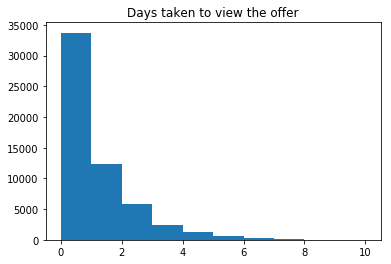

In [32]:
plt.hist(from_received_to_viewed['time_received_to_viewed'])
plt.title("Days taken to view the offer")

In [33]:
print("{:.2%} of the offer can be viewed within 1 day"\
      .format(sum(from_received_to_viewed['time_received_to_viewed'] <= 1)/len(from_received_to_viewed)))

66.96% of the offer can be viewed within 1 day


## 2.3.2 Match offer_received with offer_completed

In [34]:
#use the same logic to match offer_received and offer_completed

from_received_to_completed = transcript[transcript['event'] == "offer received"][['person', 'offer_id', 'event','time','rank_in_user']]\
                                        .merge(transcript[transcript['event'] == "offer completed"][['person', 'offer_id', 'event','time','rank_in_user']], 
                                                  on=['person', 'offer_id'], how='left')\
                                        .merge(portfolio[['id','duration']].rename({'id':'offer_id'}, axis=1))

from_received_to_completed['time_received_to_completed'] = from_received_to_completed['time_y'] - from_received_to_completed['time_x']

from_received_to_completed = from_received_to_completed[(from_received_to_completed['rank_in_user_x'] < from_received_to_completed['rank_in_user_y']) & \
                                                                           (from_received_to_completed['time_received_to_completed'] <= from_received_to_completed['duration']*24)]


from_received_to_completed = from_received_to_completed\
                                        .sort_values('rank_in_user_y').groupby(['person','offer_id','rank_in_user_x']).first().reset_index()\
                                        .sort_values('rank_in_user_x').groupby(['person','offer_id','rank_in_user_y']).first().reset_index()

from_received_to_completed['time_received_to_completed'] = (from_received_to_completed['time_y'] - from_received_to_completed['time_x']) / 24

In [35]:
#check whether the matches are unique; the below 3 numbers should be the same
print(len(from_received_to_completed))
print(len(from_received_to_completed[['person','offer_id','rank_in_user_x']].drop_duplicates()))
print(len(from_received_to_completed[['person','offer_id','rank_in_user_y']].drop_duplicates()))

33101
33101
33101


## 2.3.3 Create a table to reflect the funnel

offer_received 
<br>|__ offer viewed 
<br>&nbsp; &nbsp; &nbsp; |__ offer completed
<br>&nbsp; &nbsp; &nbsp; |__ offer not completed
<br>|__ offer not viewed
<br>&nbsp; &nbsp; &nbsp; |__ offer completed
<br>&nbsp; &nbsp; &nbsp; |__ offer not completed

In [36]:
offer_pipe = transcript[transcript['event'] == "offer received"][['person', 'offer_id','time','rank_in_user','event']]\
                    .merge(from_received_to_viewed[['person','offer_id','rank_in_user_x','event_y','time_received_to_viewed']]\
                              .rename({'rank_in_user_x':'rank_in_user'}, axis=1), 
                              on=['person','offer_id','rank_in_user'], how="left")\
                    .merge(from_received_to_completed[['person','offer_id','rank_in_user_x','event_y','time_received_to_completed']]\
                              .rename({'rank_in_user_x':'rank_in_user'}, axis=1), 
                              on=['person','offer_id','rank_in_user'], how="left")
offer_pipe['viewed'] = offer_pipe['event_y_x'].notna()
offer_pipe['time_viewed_to_completed'] = offer_pipe['time_received_to_completed'] - offer_pipe['time_received_to_viewed']

In [37]:
#check whether the matches are unique; the below 3 numbers should be the same
#in offer pipe, each row is a unique offer
print(len(offer_pipe))
print(len(offer_pipe[['person','offer_id','rank_in_user']].drop_duplicates()))
print(len(transcript[transcript['event'] == "offer received"][['person','offer_id','rank_in_user']].drop_duplicates()))

76277
76277
76277


/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tianyiwang/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'Days taken to complete the offer')

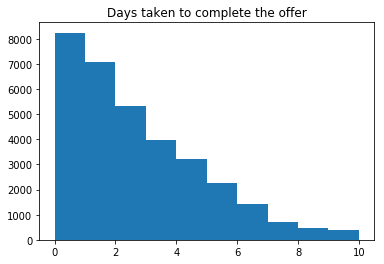

In [38]:
plt.hist(offer_pipe['time_received_to_completed'])
plt.title("Days taken to complete the offer")

Text(0.5, 1.0, 'Days taken from viewing the offer to completing the offer')

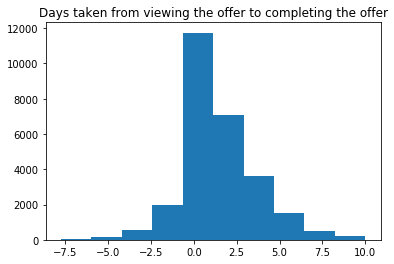

In [39]:
plt.hist(offer_pipe['time_received_to_completed'] - offer_pipe['time_received_to_viewed'])
plt.title("Days taken from viewing the offer to completing the offer")

Notice that the negative numbers mean that the offers were completed before viewed. This means that the customer made the purchase that already qualified for the promotion although they didn't know about the promotion.

In [40]:
print("{:.2%} offers were viewed."\
      .format((sum(offer_pipe[offer_p]['viewed']))/len(offer_pipe)))

74.16% offers were viewed.


In [41]:
print("{:.2%} offers were completed without being viewed."\
       .format(sum((offer_pipe['event_y_x'].isna() & offer_pipe['event_y_y'].notna()) | \
       (offer_pipe['time_received_to_completed'] < offer_pipe['time_received_to_viewed']))/len(offer_pipe)))

12.86% offers were completed without being viewed.


In [42]:
print("{:.2%} of the offer will be completed within one day after being viewed"\
        .format(sum((offer_pipe['time_received_to_completed'] - offer_pipe['time_received_to_viewed'] <= 1) & \
                   (offer_pipe['time_received_to_completed'] - offer_pipe['time_received_to_viewed'] >= 0)) / len(offer_pipe)))

13.54% of the offer will be completed within one day after being viewed


In [43]:
view_complete = offer_pipe['event_y_x'].notna() & offer_pipe['event_y_y'].notna()
view_not_complete = offer_pipe['event_y_x'].notna() & offer_pipe['event_y_y'].isna()
not_view_complete = offer_pipe['event_y_x'].isna() & offer_pipe['event_y_y'].notna()
not_view_not_complete = offer_pipe['event_y_x'].isna() & offer_pipe['event_y_y'].isna()

In [44]:
offer_pipe['viewed'] = offer_pipe['event_y_x'].notna()
offer_pipe['completed'] = offer_pipe['event_y_y'].notna()

In [45]:
offer_pipe.groupby(['viewed','completed']).count()['person'].reset_index()

,viewed,completed,person
0,False,False,13995
1,False,True,5715
2,True,False,29181
3,True,True,27386


In [46]:
(5715)/(13995+5715+29181+27386)

0.07492428910418605

In [47]:
print("{} people didn't receive any offer".format(len(transcript['person'].unique()) - len(offer_pipe['person'].unique())))

6 people didn't receive any offer


# 3. Put things together -- describe our customers

Right now we have customers' demographics, their transactions and promotion related data. We will put these things together to see whether there are any interesting insights.

In [48]:
final_table = offer_pipe.drop(['event','event_y_x','event_y_y'], axis=1)\
.merge(portfolio[['id','offer_type','difficulty','duration','reward']].rename({'id':'offer_id'}, axis=1), on='offer_id')\
.merge(profile.rename({'id':'person'}, axis=1)[['person','age','gender','age_bucket','customer_age','income']], on='person')

In [49]:
print(len(offer_pipe))
print(len(final_table))

76277
76277


Besides offers, we also want to create some features around the transactions.

In [50]:
t1 = transcript[transcript['event'] == "transaction"]
t2 = transcript[transcript['event'] == "offer completed"]

per_person = profile.rename({'id':'person'}, axis=1)[['person','age','gender','age_bucket','customer_age']]\
.merge(t1.groupby('person').count()['index'].reset_index().rename({'index':'numbers_of_purchases'}, axis=1).fillna(0), on='person', how='left')\
.merge(t1.groupby('person')['amount'].sum().reset_index().rename({'amount':'total_purchase_amount'}, axis=1).fillna(0), on='person', how='left')\
.merge(t2.groupby('person')['reward'].sum().reset_index().rename({'reward':'total_reward_amount'}, axis=1).fillna(0), on='person', how='left')

per_person['net_revenue'] = per_person['total_purchase_amount'] - per_person['total_reward_amount']

In [51]:
per_person.head()

,person,age,gender,age_bucket,customer_age,numbers_of_purchases,total_purchase_amount,total_reward_amount,net_revenue
0,68be06ca386d4c31939f3a4f0e3dd783,NaN,None,65 ~,39.366667,9.0,20.40,5.0,15.40
1,0610b486422d4921ae7d2bf64640c50b,55.0,F,55 ~ 64,34.266667,3.0,77.01,5.0,72.01
2,38fe809add3b4fcf9315a9694bb96ff5,NaN,None,65 ~,22.200000,6.0,14.30,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,F,65 ~,36.500000,7.0,159.27,20.0,139.27
4,a03223e636434f42ac4c3df47e8bac43,NaN,None,65 ~,33.600000,3.0,4.65,NaN,NaN


In [52]:
final_table.head()

,person,offer_id,time,rank_in_user,time_received_to_viewed,time_received_to_completed,viewed,time_viewed_to_completed,completed,offer_type,difficulty,duration,reward,age,gender,age_bucket,customer_age,income
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1.0,0.25,5.50,True,5.25,True,bogo,5,7,5,75.0,F,65 ~,36.500000,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,13.0,3.25,0.25,True,-3.00,True,bogo,5,5,5,75.0,F,65 ~,36.500000,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,11.0,0.00,4.25,True,4.25,True,bogo,10,7,10,75.0,F,65 ~,36.500000,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,6.0,2.00,NaN,True,NaN,False,informational,0,3,0,75.0,F,65 ~,36.500000,100000.0
4,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1.0,NaN,NaN,False,NaN,False,bogo,5,7,5,59.0,M,55 ~ 64,64.466667,41000.0


> We now have 2 tables:
<br>`final_table`: This table is on the offer level --- each row is a unique offer. We can use this table to see the statuses of the offers --- was the offer viewed? Was the offer completed?...
<br>`per_person`: This table is on customer level --- each row is a unique customer. We can use this table to get an overview of each customer --- how many purchases they have made so far? What are their net revenues?...

> In this data exploration section, we will answer these 2 questions: 
> #### (1) What types of customers are more reponsive to each type of campaigns? (2) What types of customers are more valuable?

In [53]:
final_table_not_viewed = final_table[~final_table['viewed']]
final_table_viewed = final_table[final_table['viewed']]

In [54]:
def complete_rate_compare(x):
    final_table_not_viewed.groupby(x)['completed'].mean().reset_index()\
    .merge(final_table_viewed.groupby(x)['completed'].mean().reset_index(), on=x)\
    .rename({'completed_x':'not_viewed', 'completed_y':'viewed'}, axis=1)\
    .set_index(x).plot.bar()
    plt.title("Offer completion rate")
    plt.xticks(rotation = 0)

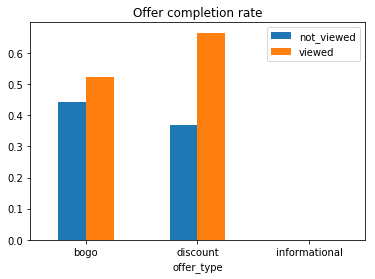

In [55]:
complete_rate_compare('offer_type')

>In general, offers that are viewed are more likely to be completed, especially for discount promotions. This is also because discount offers usually require higher amount of purchases, while buy-one-get-one is easier to achieve.

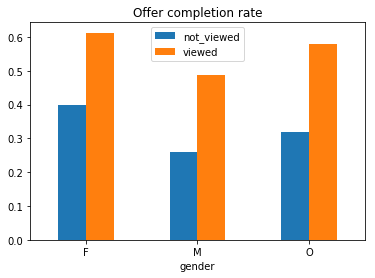

In [56]:
complete_rate_compare('gender')

> Female customers are more likely to complete the offers

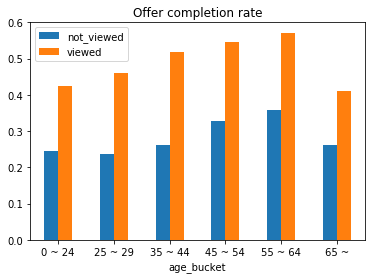

In [57]:
complete_rate_compare('age_bucket')

> Older customers are more likely to complete the offers

In [58]:
df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])

Text(0.5, 1.0, 'Income and whether the customer completed the offer')

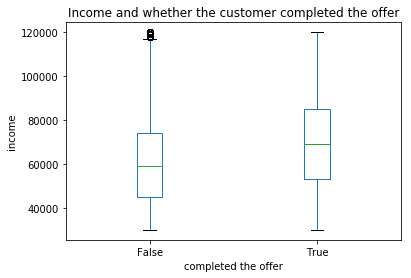

In [59]:
final_table[['completed','income']].pivot(columns="completed")['income'].plot.box()
plt.xlabel('completed the offer')
plt.ylabel('income')
plt.title("Income and whether the customer completed the offer")

>Income level is a positive factor

Text(0.5, 1.0, "'Customer age' and whether the customer completed the offer")

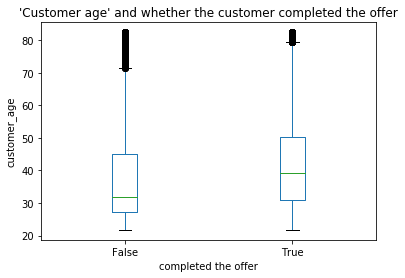

In [60]:
final_table[['completed','customer_age']].pivot(columns="completed")['customer_age'].plot.box()
plt.xlabel('completed the offer')
plt.ylabel('customer_age')
plt.title("'Customer age' and whether the customer completed the offer")

In [61]:
final_table.groupby('offer_type').count()['person']

offer_type
bogo             30499
discount         30543
informational    15235
Name: person, dtype: int64

In [62]:
final_table.groupby(['offer_id','offer_type']).count()['person']

offer_id                          offer_type   
0b1e1539f2cc45b7b9fa7c272da2e1d7  discount         7668
2298d6c36e964ae4a3e7e9706d1fb8c2  discount         7646
2906b810c7d4411798c6938adc9daaa5  discount         7632
3f207df678b143eea3cee63160fa8bed  informational    7617
4d5c57ea9a6940dd891ad53e9dbe8da0  bogo             7593
5a8bc65990b245e5a138643cd4eb9837  informational    7618
9b98b8c7a33c4b65b9aebfe6a799e6d9  bogo             7677
ae264e3637204a6fb9bb56bc8210ddfd  bogo             7658
f19421c1d4aa40978ebb69ca19b0e20d  bogo             7571
fafdcd668e3743c1bb461111dcafc2a4  discount         7597
Name: person, dtype: int64

> The distribution among offers is quite balanced.

In [63]:
def average_net_revenue_by_group(x):
    per_person.groupby(x)['net_revenue'].mean().plot.bar()
    plt.title("Average Net Revenue")
    plt.xticks(rotation = 0)

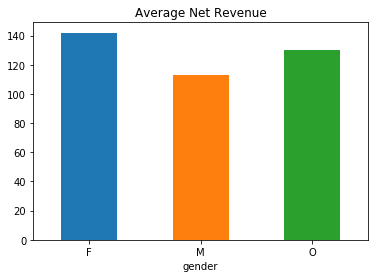

In [64]:
average_net_revenue_by_group('gender')

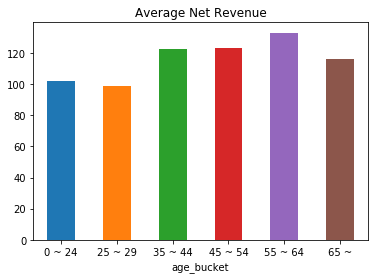

In [65]:
average_net_revenue_by_group('age_bucket')

Text(0, 0.5, 'net revenue')

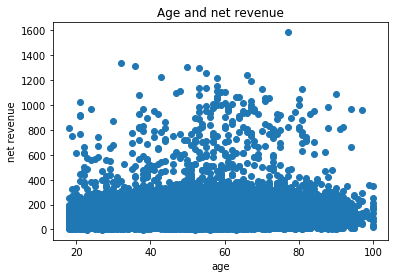

In [66]:
plt.scatter(per_person['age'], per_person['net_revenue'])
plt.title('Age and net revenue')
plt.xlabel('age')
plt.ylabel('net revenue')

Text(0, 0.5, 'net revenue')

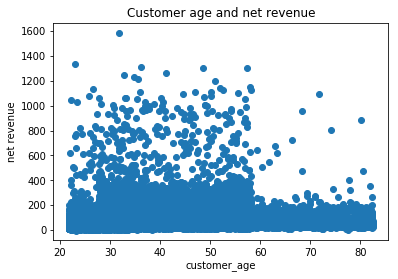

In [67]:
plt.scatter(per_person['customer_age'], per_person['net_revenue'])
plt.title('Customer age and net revenue')
plt.xlabel('customer_age')
plt.ylabel('net revenue')

Text(0, 0.5, 'net_revenue')

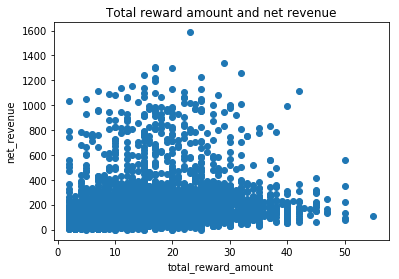

In [68]:
plt.scatter(per_person['total_reward_amount'], per_person['net_revenue'])
plt.title("Total reward amount and net revenue")
plt.xlabel('total_reward_amount')
plt.ylabel('net_revenue')

# 4. Prepare data for machine learning models

In [69]:
offer_pipe['time_viewed_to_completed'] = offer_pipe['time_received_to_completed'] - offer_pipe['time_received_to_viewed']
offer_pipe['completed'] = offer_pipe['event_y_y'].notna()
offer_pipe['effectively_viewed'] = offer_pipe['viewed'] & \
                                               ((offer_pipe['time_viewed_to_completed'] >= 0) | (~offer_pipe['completed']))

In [70]:
print("{:.2%} of the offers were effectively viewed (not viewed after they had completed the offer)"\
       .format(sum(offer_pipe['effectively_viewed']) / len(offer_pipe)))

68.79% of the offers were effectively viewed (not viewed after they had completed the offer)


In [71]:
def numeric_gender(x):
    if x is None:
        return 0.5
    if x == "F":
        return 0
    else:
        return 1

profile['gender'] = profile['gender'].apply(numeric_gender)

In [72]:
offer_pipe_for_modeling = offer_pipe.drop(['rank_in_user', 
                                           'event', 
                                           'event_y_x', 
                                           'time_received_to_viewed', 
                                           'time_received_to_completed',
                                           'time_viewed_to_completed',
                                           'viewed',
                                           'event_y_y'], axis=1)\
                                     .merge(portfolio[portfolio['offer_type'] != 'informational']\
                                               .rename({'id':'offer_id'}, axis=1).drop('channels', axis=1), on="offer_id")\
                                     .merge(profile[['age', 'gender', 'income', 'customer_age','id']].rename({'id':'person'}, axis=1))

In [73]:
offer_pipe_for_modeling.head()

,person,offer_id,time,completed,effectively_viewed,difficulty,duration,offer_type,reward,web,mobile,email,social,age,gender,income,customer_age
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,True,True,5,7,bogo,5,1,1,1,0,75.0,0.0,100000.0,36.500000
1,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,True,False,5,5,bogo,5,1,1,1,1,75.0,0.0,100000.0,36.500000
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,True,True,10,7,bogo,10,0,1,1,1,75.0,0.0,100000.0,36.500000
3,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,False,False,5,7,bogo,5,1,1,1,0,59.0,1.0,41000.0,64.466667
4,ebe7ef46ea6f4963a7dd49f501b26779,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,False,True,5,7,bogo,5,1,1,1,0,59.0,1.0,41000.0,64.466667


In [74]:
offer_pipe_for_modeling.to_csv('offer_pipe_for_modeling.csv', index=False)

> # Appendix
Prove that until the current offer expires, the app won't send another offer under the same type to that customer

In [75]:
t1 = transcript[transcript['event'] == "offer received"][['person','time','offer_id','rank_in_user']]\
.merge(portfolio[['id','duration']].rename({'id':'offer_id'}, axis=1))\
.merge(transcript[transcript['event'] == "offer received"][['person','time','offer_id','rank_in_user']], on=['person','offer_id'])

t1['duration_calc'] = t1['time_y'] - t1['time_x'] #duration between 2 offers under the same type

t1['expiration'] = t1['time_x' ] + t1['duration'] #expiration time of the first offer 

t1 = t1[(t1['duration_calc'] > 0) & (t1['expiration'] >= t1['time_y'])] #the offer on the right should be later than the offer on the left 
#and we add a filter to get the later offer that comes before the earlier offer expires

In [76]:
t1

,person,time_x,offer_id,rank_in_user_x,duration,time_y,rank_in_user_y,duration_calc,expiration
